Epoch 1/50


c:\Users\danyok\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6252 - loss: 0.6617 - val_accuracy: 0.2194 - val_loss: 0.8943
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6636 - loss: 0.6104 - val_accuracy: 0.6200 - val_loss: 0.6847
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7026 - loss: 0.5694 - val_accuracy: 0.5678 - val_loss: 0.7271
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7262 - loss: 0.5429 - val_accuracy: 0.7256 - val_loss: 0.5685
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7540 - loss: 0.5091 - val_accuracy: 0.5380 - val_loss: 0.7851
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7627 - loss: 0.4857 - val_accuracy: 0.6162 - val_loss: 0.7070
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7727 - loss: 0.4727 - val_accuracy: 0.7624 - val_loss: 0.5099
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7827 - loss: 0.4574 - val_accuracy: 0.728

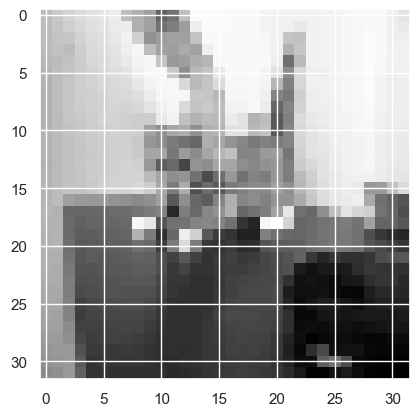

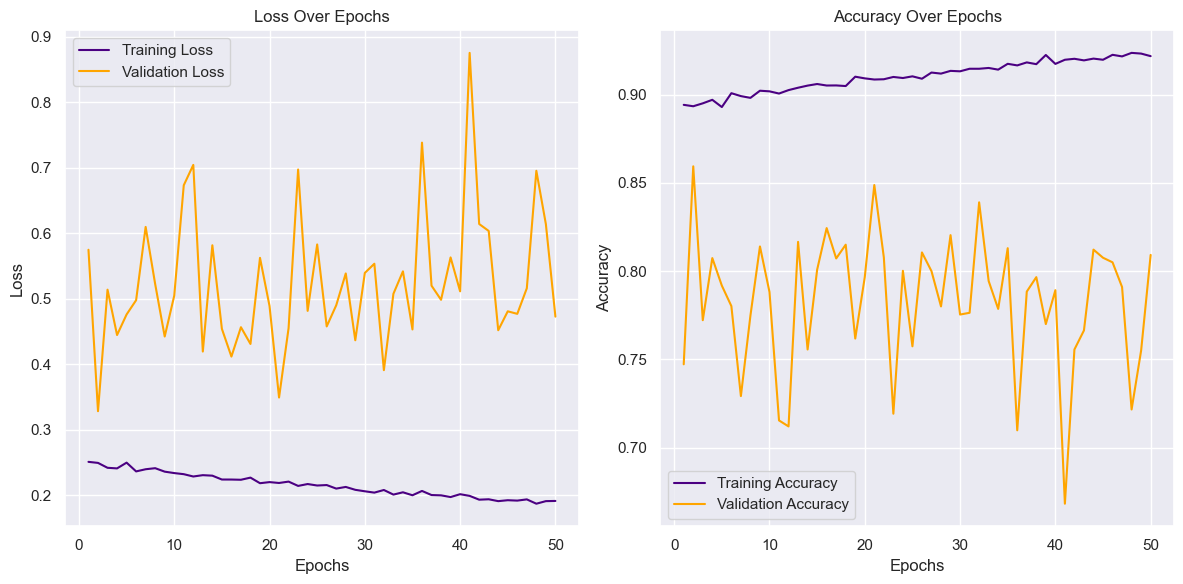

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


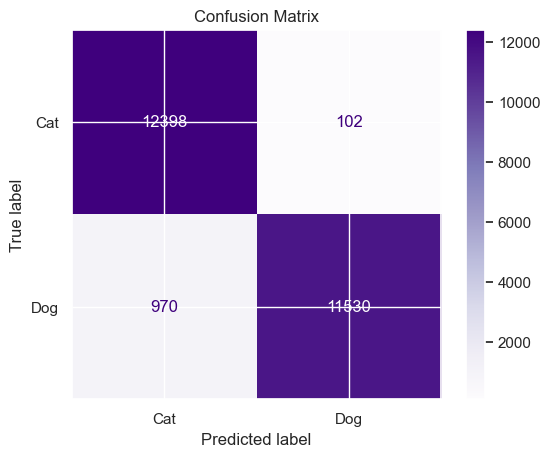

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


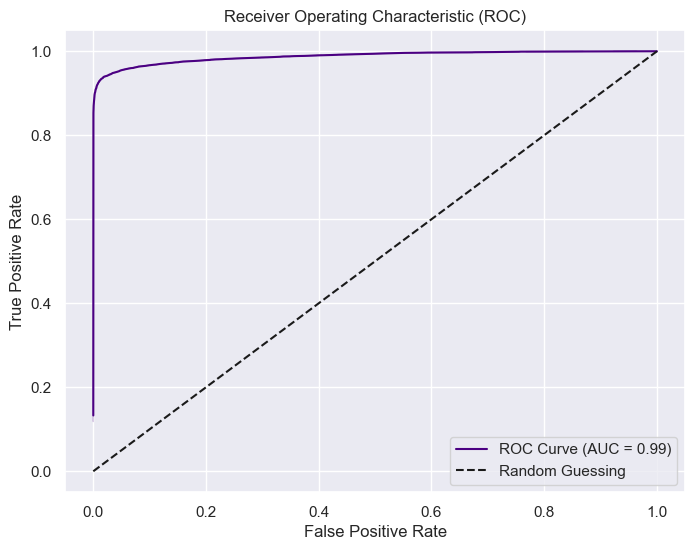

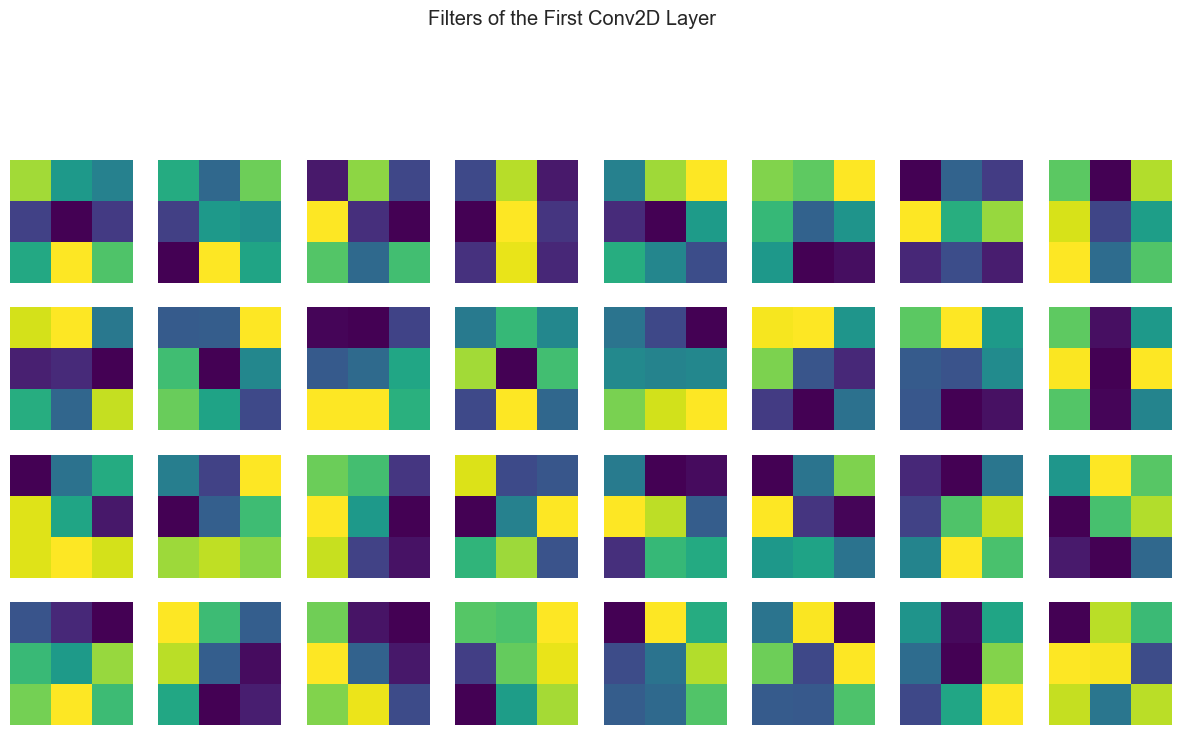

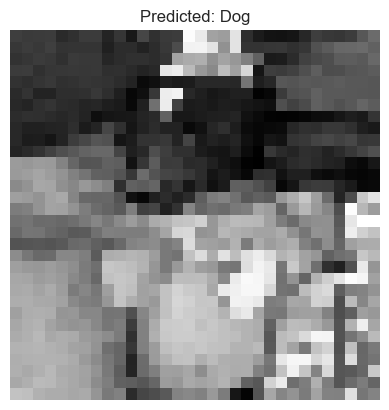

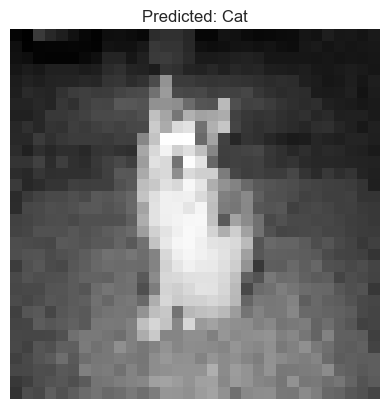

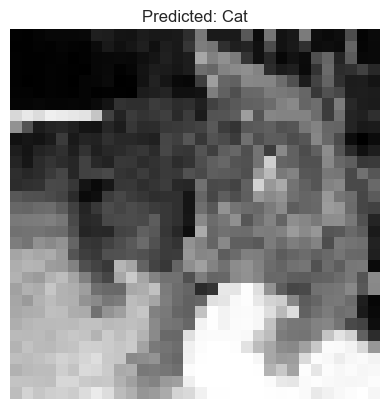

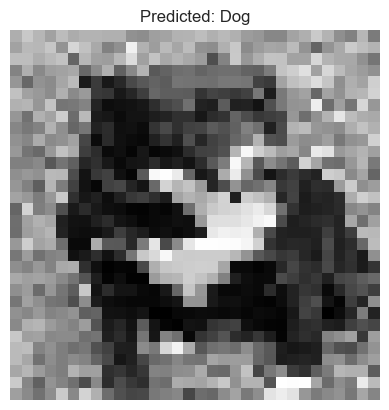

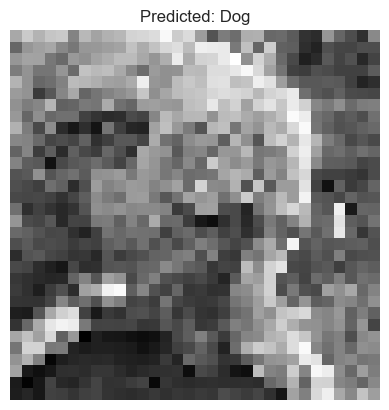

              precision    recall  f1-score   support

         Cat       0.93      0.99      0.96     12500
         Dog       0.99      0.92      0.96     12500

    accuracy                           0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000



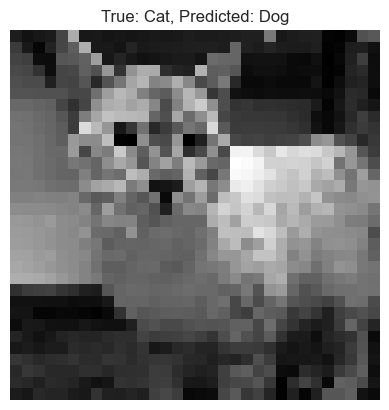

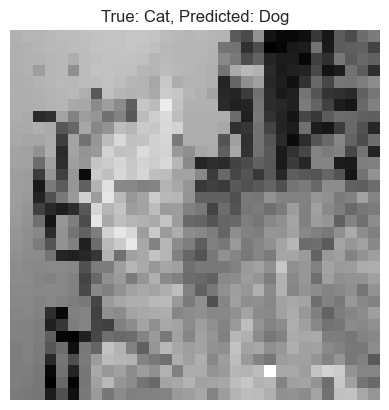

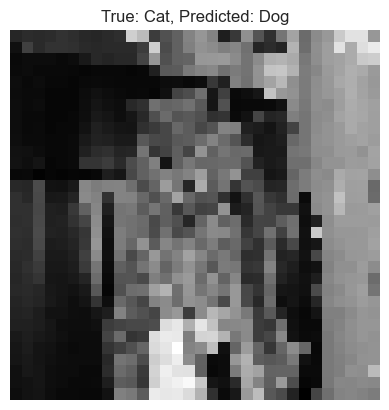

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

#Data Retrieval
import os

path = os.path.join("./ieee-ai-and-ml-demystified/train/train","")


for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(32, 32))
    plt.imshow(new_img_array,cmap="gray")
    break
    
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X.append(new_img_array)
        y.append(category)


create_test_data(path)
X = np.array(X).reshape(-1, 32,32,1)
y = np.array(y)

X = X/255.0

from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

path1 = os.path.join("./ieee-ai-and-ml-demystified/test1/test1","")

X_test = []
id_line = []
def create_test1_data(path1):
    for p in os.listdir(path1):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path1,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X_test.append(new_img_array)
create_test1_data(path1)
X_test = np.array(X_test).reshape(-1,32,32,1)
X_test = X_test/255


predictions = model.predict(X_test)

predicted_val = [int(round(p[0])) for p in predictions] 

predicted_val[0:5]


submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val}) 

submission_df.to_csv("submission123.csv", index=False)

# Обучение модели с сохранением истории
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Визуализация процесса обучения
sns.set_theme(style="darkgrid", palette="bright")
# График функции потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss', color='indigo')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy', color='indigo')
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Пример: если у вас есть тестовые данные и предсказания
y_true = y  # Истинные метки (например, обучающие данные)
y_pred = (model.predict(X) > 0.5).astype("int32")  # Предсказания модели

# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Purples')
plt.title('Confusion Matrix')
plt.show()

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y, model.predict(X))
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой для оценки качества бинарной классификации
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='indigo')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Визуализация фильтров первого сверточного слоя
filters, biases = model.layers[0].get_weights()
n_filters = filters.shape[-1]

plt.figure(figsize=(15, 15))
for i in range(n_filters):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[:, :, 0, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filters of the First Conv2D Layer')
plt.show()

# Визуализация предсказаний модели на тестовых данных
for i in range(5):
    plt.imshow(X_test[i].reshape(32, 32), cmap='gray')
    plt.title(f'Predicted: {"Dog" if predicted_val[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()

# Расчёт точности для каждого класса (cat и dog)
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Примеры изображений на которых модель ошиблась
errors = np.where(y_true != y_pred.flatten())[0]

# Визуализация ошибок
for i in errors[:3]:  # Покажем первые 5 ошибок
    plt.imshow(X[i].reshape(32, 32), cmap='gray')
    plt.title(f'True: {"Dog" if y_true[i] == 1 else "Cat"}, Predicted: {"Dog" if y_pred[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()
  